# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.782895  0.145041  1.0  0.917019 -1.086651  1.478131  2  0  31.586122   
1  1.987727 -0.341216  1.0  0.934015 -0.246119  1.867683  1  3  33.164441   
2  0.338537  0.122555  1.0  0.608897  0.601030  2.152369  2  3  39.157797   
3 -0.163607 -1.285158  1.0  0.103838 -0.922398  0.231097  1  1  14.632766   
4 -0.064959 -0.396384  0.0  0.432161 -1.016559  3.548864  3  1  26.082380   

            y  
0  322.163837  
1  360.121375  
2  453.419244  
3   62.268055  
4  233.349387  
True causal estimate is 6.01407623727617


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

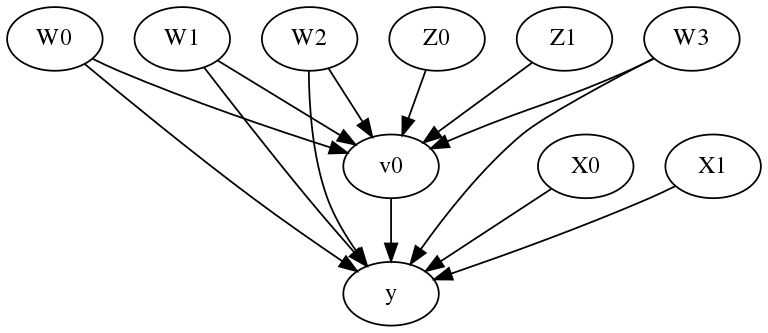

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 6.014028875671986
### Conditional Estimates
__categorical__X1            __categorical__X0
(-4.550000000000001, -1.72]  (-3.997, -0.833]     -1.720338
                             (-0.833, -0.243]     -0.851198
                             (-0.243, 0.252]      -0.567776
                             (0.252, 0.837]       -0.055740
                             (0.837, 3.362]        0.760875
(-1.72, -1.11]               (-3.997, -0.833]      2.282291
                             (-0.833, -0.243]      3.112726
                             (-0.243, 

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-03-02 10:01:53.163337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 10:01:53.163597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 7.657348929613193
Effect estimates: [10.3327175  12.13481004  4.26332721 ...  3.84335787  7.10359329
 13.03066928]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 6.01407623727617


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: 

## Estimate
Mean value: 6.003533327420517
Effect estimates: [ 9.94575759 10.23957283 10.87125431 ... 12.95236855 11.62469857
  3.13449252]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 6.028921766352337
Effect estimates: [ 9.99892019 10.30117022 10.93387369 ... 13.03214901 11.69273387
  3.13811867]
95.0% confidence interval: (array([10.08113132, 10.35020129, 11.05437566, ..., 13.16040755,
       11.82392496,  3.08825901]), array([10.33670317, 10.61427996, 11.27384704, ..., 13.46540188,
       12.07247419,  3.19933234]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[11.4162261  12.23045382 12.81991437 11.76671143 14.58384207 12.45990099
 13.14021753 14.34334017 14.01614214 13.66402252]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     1.348396  0.648338  1.0  0.628818 -1.081767 -1.343905 -1.328437   
1    -0.133037 -1.115238  1.0  0.630034  0.482899 -1.703917 -0.725005   
2     0.418985 -1.667988  0.0  0.654379 -0.014663 -1.173174  1.487145   
3     0.827159 -2.068219  0.0  0.619529  0.006745  1.183877  0.484761   
4     0.858324 -1.449263  0.0  0.249364 -1.817398  0.996118  1.094022   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.717564  0.092803  1.0  0.201227 -0.180707 -0.995503 -0.557038   
9996 -1.759688  0.294012  0.0  0.374786  1.765063  0.467362  1.401047   
9997  2.539297 -1.325200  0.0  0.929675 -1.592370 -1.635506 -0.153877   
9998  0.885167  0.087196  1.0  0.862730 -2.453999  1.358219 -0.067031   
9999  0.542590 -1.001360  0.0  0.165956  1.115864 -0.691033  0.164341   

            W3  v0  y  
0     0.022258   1  1  
1    -0.151020   1  0  
2    -1.110341   1  0  
3     0.228862   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5021210625436903
Effect estimates: [0.6543983  0.47002866 0.39849693 ... 0.409551   0.59562477 0.47409002]

True causal estimate is 0.3055


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-03-02 10:03:45.908495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-02 10:03:45.909373: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 10:03:45.909637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AMSHAR-Z840): /proc/driver/nvidia/version does not exist
2022-03-02 10:03:45.911706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:31 - loss: 197.0083

 13/313 [>.............................] - ETA: 1s - loss: 98.0557   

 28/313 [=>............................] - ETA: 1s - loss: 57.5182

 43/313 [===>..........................] - ETA: 1s - loss: 40.2465

 59/313 [====>.........................] - ETA: 0s - loss: 30.7844

 76/313 [======>.......................] - ETA: 0s - loss: 25.0217

 92/313 [=======>......................] - ETA: 0s - loss: 21.4886

109/313 [=========>....................] - ETA: 0s - loss: 18.8614

125/313 [==========>...................] - ETA: 0s - loss: 17.0291

142/313 [============>.................] - ETA: 0s - loss: 15.4958

159/313 [==============>...............] - ETA: 0s - loss: 14.2855

176/313 [===============>..............] - ETA: 0s - loss: 13.2918

192/313 [=================>............] - ETA: 0s - loss: 12.5115

209/313 [===================>..........] - ETA: 0s - loss: 11.8072

226/313 [====================>.........] - ETA: 0s - loss: 11.2000

243/313 [======================>.......] - ETA: 0s - loss: 10.6718

260/313 [=======================>......] - ETA: 0s - loss: 10.2091

277/313 [=========================>....] - ETA: 0s - loss: 9.8018 

294/313 [===========================>..] - ETA: 0s - loss: 9.4369

311/313 [============================>.] - ETA: 0s - loss: 9.1098

313/313 [==============================] - 2s 3ms/step - loss: 9.0737


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 3.5519

 18/313 [>.............................] - ETA: 0s - loss: 3.4612

 36/313 [==>...........................] - ETA: 0s - loss: 3.3779

 53/313 [====>.........................] - ETA: 0s - loss: 3.3259

 71/313 [=====>........................] - ETA: 0s - loss: 3.2902

 89/313 [=======>......................] - ETA: 0s - loss: 3.2554

107/313 [=========>....................] - ETA: 0s - loss: 3.2523

124/313 [==========>...................] - ETA: 0s - loss: 3.2303

141/313 [============>.................] - ETA: 0s - loss: 3.2135

159/313 [==============>...............] - ETA: 0s - loss: 3.2070

177/313 [===============>..............] - ETA: 0s - loss: 3.1923

195/313 [=================>............] - ETA: 0s - loss: 3.1748

213/313 [===================>..........] - ETA: 0s - loss: 3.1633

231/313 [=====================>........] - ETA: 0s - loss: 3.1473

248/313 [======================>.......] - ETA: 0s - loss: 3.1353

266/313 [========================>.....] - ETA: 0s - loss: 3.1252

284/313 [==========================>...] - ETA: 0s - loss: 3.1130

301/313 [===========================>..] - ETA: 0s - loss: 3.0999

313/313 [==============================] - 1s 3ms/step - loss: 3.0934


Epoch 3/25
  1/313 [..............................] - ETA: 1s - loss: 3.1170

 18/313 [>.............................] - ETA: 0s - loss: 2.9406

 35/313 [==>...........................] - ETA: 0s - loss: 2.9062

 52/313 [===>..........................] - ETA: 0s - loss: 2.9010

 70/313 [=====>........................] - ETA: 0s - loss: 2.9025

 87/313 [=======>......................] - ETA: 0s - loss: 2.8939

105/313 [=========>....................] - ETA: 0s - loss: 2.8837

123/313 [==========>...................] - ETA: 0s - loss: 2.8762

141/313 [============>.................] - ETA: 0s - loss: 2.8745

159/313 [==============>...............] - ETA: 0s - loss: 2.8639

177/313 [===============>..............] - ETA: 0s - loss: 2.8679

193/313 [=================>............] - ETA: 0s - loss: 2.8618

207/313 [==================>...........] - ETA: 0s - loss: 2.8591

225/313 [====================>.........] - ETA: 0s - loss: 2.8534

243/313 [======================>.......] - ETA: 0s - loss: 2.8505

261/313 [========================>.....] - ETA: 0s - loss: 2.8444

279/313 [=========================>....] - ETA: 0s - loss: 2.8447

297/313 [===========================>..] - ETA: 0s - loss: 2.8400

313/313 [==============================] - 1s 3ms/step - loss: 2.8343


Epoch 4/25
  1/313 [..............................] - ETA: 1s - loss: 3.0857

 19/313 [>.............................] - ETA: 0s - loss: 2.8212

 37/313 [==>...........................] - ETA: 0s - loss: 2.7888

 55/313 [====>.........................] - ETA: 0s - loss: 2.7760

 73/313 [=====>........................] - ETA: 0s - loss: 2.7814

 91/313 [=======>......................] - ETA: 0s - loss: 2.7731

109/313 [=========>....................] - ETA: 0s - loss: 2.7754

127/313 [===========>..................] - ETA: 0s - loss: 2.7705

144/313 [============>.................] - ETA: 0s - loss: 2.7661

161/313 [==============>...............] - ETA: 0s - loss: 2.7542

178/313 [================>.............] - ETA: 0s - loss: 2.7483

196/313 [=================>............] - ETA: 0s - loss: 2.7488

214/313 [===================>..........] - ETA: 0s - loss: 2.7463

233/313 [=====================>........] - ETA: 0s - loss: 2.7454

251/313 [=======================>......] - ETA: 0s - loss: 2.7441

269/313 [========================>.....] - ETA: 0s - loss: 2.7383

287/313 [==========================>...] - ETA: 0s - loss: 2.7373

305/313 [============================>.] - ETA: 0s - loss: 2.7344

313/313 [==============================] - 1s 3ms/step - loss: 2.7343


Epoch 5/25
  1/313 [..............................] - ETA: 1s - loss: 2.8060

 18/313 [>.............................] - ETA: 0s - loss: 2.7013

 36/313 [==>...........................] - ETA: 0s - loss: 2.7260

 53/313 [====>.........................] - ETA: 0s - loss: 2.7053

 71/313 [=====>........................] - ETA: 0s - loss: 2.7182

 89/313 [=======>......................] - ETA: 0s - loss: 2.7216

107/313 [=========>....................] - ETA: 0s - loss: 2.7146

125/313 [==========>...................] - ETA: 0s - loss: 2.7116

143/313 [============>.................] - ETA: 0s - loss: 2.7077

161/313 [==============>...............] - ETA: 0s - loss: 2.7043

180/313 [================>.............] - ETA: 0s - loss: 2.7046

198/313 [=================>............] - ETA: 0s - loss: 2.7042

217/313 [===================>..........] - ETA: 0s - loss: 2.7029

235/313 [=====================>........] - ETA: 0s - loss: 2.7022

253/313 [=======================>......] - ETA: 0s - loss: 2.6988

272/313 [=========================>....] - ETA: 0s - loss: 2.6947

290/313 [==========================>...] - ETA: 0s - loss: 2.6914

309/313 [============================>.] - ETA: 0s - loss: 2.6934

313/313 [==============================] - 1s 3ms/step - loss: 2.6933


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 2.8135

 19/313 [>.............................] - ETA: 0s - loss: 2.6725

 37/313 [==>...........................] - ETA: 0s - loss: 2.6523

 55/313 [====>.........................] - ETA: 0s - loss: 2.6433

 73/313 [=====>........................] - ETA: 0s - loss: 2.6415

 91/313 [=======>......................] - ETA: 0s - loss: 2.6660

109/313 [=========>....................] - ETA: 0s - loss: 2.6584

128/313 [===========>..................] - ETA: 0s - loss: 2.6584

146/313 [============>.................] - ETA: 0s - loss: 2.6632

164/313 [==============>...............] - ETA: 0s - loss: 2.6585

182/313 [================>.............] - ETA: 0s - loss: 2.6562

201/313 [==================>...........] - ETA: 0s - loss: 2.6622

219/313 [===================>..........] - ETA: 0s - loss: 2.6636

237/313 [=====================>........] - ETA: 0s - loss: 2.6634

255/313 [=======================>......] - ETA: 0s - loss: 2.6648

273/313 [=========================>....] - ETA: 0s - loss: 2.6622

292/313 [==========================>...] - ETA: 0s - loss: 2.6634

310/313 [============================>.] - ETA: 0s - loss: 2.6592

313/313 [==============================] - 1s 3ms/step - loss: 2.6578


Epoch 7/25
  1/313 [..............................] - ETA: 0s - loss: 2.8732

 20/313 [>.............................] - ETA: 0s - loss: 2.6867

 39/313 [==>...........................] - ETA: 0s - loss: 2.6708

 57/313 [====>.........................] - ETA: 0s - loss: 2.6660

 75/313 [======>.......................] - ETA: 0s - loss: 2.6506

 93/313 [=======>......................] - ETA: 0s - loss: 2.6579

112/313 [=========>....................] - ETA: 0s - loss: 2.6503

130/313 [===========>..................] - ETA: 0s - loss: 2.6488

148/313 [=============>................] - ETA: 0s - loss: 2.6429

166/313 [==============>...............] - ETA: 0s - loss: 2.6395

185/313 [================>.............] - ETA: 0s - loss: 2.6420

204/313 [==================>...........] - ETA: 0s - loss: 2.6448

222/313 [====================>.........] - ETA: 0s - loss: 2.6459

241/313 [======================>.......] - ETA: 0s - loss: 2.6447

259/313 [=======================>......] - ETA: 0s - loss: 2.6410

278/313 [=========================>....] - ETA: 0s - loss: 2.6436

296/313 [===========================>..] - ETA: 0s - loss: 2.6447

313/313 [==============================] - 1s 3ms/step - loss: 2.6463


Epoch 8/25
  1/313 [..............................] - ETA: 1s - loss: 2.6755

 19/313 [>.............................] - ETA: 0s - loss: 2.6445

 37/313 [==>...........................] - ETA: 0s - loss: 2.6160

 55/313 [====>.........................] - ETA: 0s - loss: 2.6239

 72/313 [=====>........................] - ETA: 0s - loss: 2.6338

 90/313 [=======>......................] - ETA: 0s - loss: 2.6284

108/313 [=========>....................] - ETA: 0s - loss: 2.6273

126/313 [===========>..................] - ETA: 0s - loss: 2.6323

144/313 [============>.................] - ETA: 0s - loss: 2.6349

163/313 [==============>...............] - ETA: 0s - loss: 2.6348

182/313 [================>.............] - ETA: 0s - loss: 2.6322

200/313 [==================>...........] - ETA: 0s - loss: 2.6349

219/313 [===================>..........] - ETA: 0s - loss: 2.6358

237/313 [=====================>........] - ETA: 0s - loss: 2.6380

255/313 [=======================>......] - ETA: 0s - loss: 2.6384

274/313 [=========================>....] - ETA: 0s - loss: 2.6343

292/313 [==========================>...] - ETA: 0s - loss: 2.6362

310/313 [============================>.] - ETA: 0s - loss: 2.6354

313/313 [==============================] - 1s 3ms/step - loss: 2.6363


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 2.7806

 19/313 [>.............................] - ETA: 0s - loss: 2.6956

 37/313 [==>...........................] - ETA: 0s - loss: 2.6623

 55/313 [====>.........................] - ETA: 0s - loss: 2.6547

 74/313 [======>.......................] - ETA: 0s - loss: 2.6347

 93/313 [=======>......................] - ETA: 0s - loss: 2.6281

112/313 [=========>....................] - ETA: 0s - loss: 2.6331

130/313 [===========>..................] - ETA: 0s - loss: 2.6304

148/313 [=============>................] - ETA: 0s - loss: 2.6228

166/313 [==============>...............] - ETA: 0s - loss: 2.6252

185/313 [================>.............] - ETA: 0s - loss: 2.6232

203/313 [==================>...........] - ETA: 0s - loss: 2.6223

221/313 [====================>.........] - ETA: 0s - loss: 2.6241

240/313 [======================>.......] - ETA: 0s - loss: 2.6263

258/313 [=======================>......] - ETA: 0s - loss: 2.6268

276/313 [=========================>....] - ETA: 0s - loss: 2.6280

294/313 [===========================>..] - ETA: 0s - loss: 2.6283

313/313 [==============================] - ETA: 0s - loss: 2.6308

313/313 [==============================] - 1s 3ms/step - loss: 2.6308


Epoch 10/25
  1/313 [..............................] - ETA: 1s - loss: 2.4690

 20/313 [>.............................] - ETA: 0s - loss: 2.5905

 38/313 [==>...........................] - ETA: 0s - loss: 2.5816

 56/313 [====>.........................] - ETA: 0s - loss: 2.5740

 75/313 [======>.......................] - ETA: 0s - loss: 2.5895

 94/313 [========>.....................] - ETA: 0s - loss: 2.5942

112/313 [=========>....................] - ETA: 0s - loss: 2.5936

131/313 [===========>..................] - ETA: 0s - loss: 2.5945

150/313 [=============>................] - ETA: 0s - loss: 2.5968

168/313 [===============>..............] - ETA: 0s - loss: 2.6035

186/313 [================>.............] - ETA: 0s - loss: 2.6084

205/313 [==================>...........] - ETA: 0s - loss: 2.6044

223/313 [====================>.........] - ETA: 0s - loss: 2.6070

242/313 [======================>.......] - ETA: 0s - loss: 2.6062

261/313 [========================>.....] - ETA: 0s - loss: 2.6100

279/313 [=========================>....] - ETA: 0s - loss: 2.6123

298/313 [===========================>..] - ETA: 0s - loss: 2.6110

313/313 [==============================] - 1s 3ms/step - loss: 2.6108


Epoch 11/25
  1/313 [..............................] - ETA: 1s - loss: 2.6812

 19/313 [>.............................] - ETA: 0s - loss: 2.6211

 37/313 [==>...........................] - ETA: 0s - loss: 2.6188

 56/313 [====>.........................] - ETA: 0s - loss: 2.6147

 74/313 [======>.......................] - ETA: 0s - loss: 2.6095

 93/313 [=======>......................] - ETA: 0s - loss: 2.6124

111/313 [=========>....................] - ETA: 0s - loss: 2.6091

129/313 [===========>..................] - ETA: 0s - loss: 2.6013

147/313 [=============>................] - ETA: 0s - loss: 2.6018

165/313 [==============>...............] - ETA: 0s - loss: 2.6041

183/313 [================>.............] - ETA: 0s - loss: 2.5993

202/313 [==================>...........] - ETA: 0s - loss: 2.6030

220/313 [====================>.........] - ETA: 0s - loss: 2.6047

238/313 [=====================>........] - ETA: 0s - loss: 2.6057

256/313 [=======================>......] - ETA: 0s - loss: 2.6073

275/313 [=========================>....] - ETA: 0s - loss: 2.6058

293/313 [===========================>..] - ETA: 0s - loss: 2.6082

312/313 [============================>.] - ETA: 0s - loss: 2.6073

313/313 [==============================] - 1s 3ms/step - loss: 2.6070


Epoch 12/25
  1/313 [..............................] - ETA: 0s - loss: 2.4664

 19/313 [>.............................] - ETA: 0s - loss: 2.6142

 37/313 [==>...........................] - ETA: 0s - loss: 2.6121

 55/313 [====>.........................] - ETA: 0s - loss: 2.6063

 73/313 [=====>........................] - ETA: 0s - loss: 2.5995

 91/313 [=======>......................] - ETA: 0s - loss: 2.5939

109/313 [=========>....................] - ETA: 0s - loss: 2.5961

127/313 [===========>..................] - ETA: 0s - loss: 2.5988

146/313 [============>.................] - ETA: 0s - loss: 2.6021

164/313 [==============>...............] - ETA: 0s - loss: 2.6033

182/313 [================>.............] - ETA: 0s - loss: 2.5984

200/313 [==================>...........] - ETA: 0s - loss: 2.6000

218/313 [===================>..........] - ETA: 0s - loss: 2.5993

236/313 [=====================>........] - ETA: 0s - loss: 2.6004

255/313 [=======================>......] - ETA: 0s - loss: 2.6018

273/313 [=========================>....] - ETA: 0s - loss: 2.6004

291/313 [==========================>...] - ETA: 0s - loss: 2.6023

310/313 [============================>.] - ETA: 0s - loss: 2.6007

313/313 [==============================] - 1s 3ms/step - loss: 2.6005


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 2.7019

 19/313 [>.............................] - ETA: 0s - loss: 2.6425

 37/313 [==>...........................] - ETA: 0s - loss: 2.6174

 55/313 [====>.........................] - ETA: 0s - loss: 2.6186

 74/313 [======>.......................] - ETA: 0s - loss: 2.6141

 92/313 [=======>......................] - ETA: 0s - loss: 2.6187

110/313 [=========>....................] - ETA: 0s - loss: 2.6191

128/313 [===========>..................] - ETA: 0s - loss: 2.6162

146/313 [============>.................] - ETA: 0s - loss: 2.6119

164/313 [==============>...............] - ETA: 0s - loss: 2.6071

182/313 [================>.............] - ETA: 0s - loss: 2.5997

200/313 [==================>...........] - ETA: 0s - loss: 2.6020

218/313 [===================>..........] - ETA: 0s - loss: 2.5982

236/313 [=====================>........] - ETA: 0s - loss: 2.6004

254/313 [=======================>......] - ETA: 0s - loss: 2.5969

272/313 [=========================>....] - ETA: 0s - loss: 2.5979

290/313 [==========================>...] - ETA: 0s - loss: 2.5983

308/313 [============================>.] - ETA: 0s - loss: 2.5978

313/313 [==============================] - 1s 3ms/step - loss: 2.5973


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 2.7880

 19/313 [>.............................] - ETA: 0s - loss: 2.6026

 37/313 [==>...........................] - ETA: 0s - loss: 2.6218

 56/313 [====>.........................] - ETA: 0s - loss: 2.6153

 74/313 [======>.......................] - ETA: 0s - loss: 2.6032

 92/313 [=======>......................] - ETA: 0s - loss: 2.6006

110/313 [=========>....................] - ETA: 0s - loss: 2.5944

128/313 [===========>..................] - ETA: 0s - loss: 2.5927

147/313 [=============>................] - ETA: 0s - loss: 2.5944

165/313 [==============>...............] - ETA: 0s - loss: 2.5969

183/313 [================>.............] - ETA: 0s - loss: 2.5924

201/313 [==================>...........] - ETA: 0s - loss: 2.5961

219/313 [===================>..........] - ETA: 0s - loss: 2.5971

237/313 [=====================>........] - ETA: 0s - loss: 2.6010

255/313 [=======================>......] - ETA: 0s - loss: 2.6034

273/313 [=========================>....] - ETA: 0s - loss: 2.6013

292/313 [==========================>...] - ETA: 0s - loss: 2.6019

310/313 [============================>.] - ETA: 0s - loss: 2.5997

313/313 [==============================] - 1s 3ms/step - loss: 2.5988


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 2.6499

 19/313 [>.............................] - ETA: 0s - loss: 2.6079

 38/313 [==>...........................] - ETA: 0s - loss: 2.5918

 56/313 [====>.........................] - ETA: 0s - loss: 2.5889

 74/313 [======>.......................] - ETA: 0s - loss: 2.5803

 92/313 [=======>......................] - ETA: 0s - loss: 2.5731

111/313 [=========>....................] - ETA: 0s - loss: 2.5767

130/313 [===========>..................] - ETA: 0s - loss: 2.5776

149/313 [=============>................] - ETA: 0s - loss: 2.5858

168/313 [===============>..............] - ETA: 0s - loss: 2.5841

187/313 [================>.............] - ETA: 0s - loss: 2.5865

206/313 [==================>...........] - ETA: 0s - loss: 2.5887

226/313 [====================>.........] - ETA: 0s - loss: 2.5851

245/313 [======================>.......] - ETA: 0s - loss: 2.5848

264/313 [========================>.....] - ETA: 0s - loss: 2.5897

283/313 [==========================>...] - ETA: 0s - loss: 2.5936

302/313 [===========================>..] - ETA: 0s - loss: 2.5946

313/313 [==============================] - 1s 3ms/step - loss: 2.5935


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 2.3189

 20/313 [>.............................] - ETA: 0s - loss: 2.5835

 38/313 [==>...........................] - ETA: 0s - loss: 2.5888

 56/313 [====>.........................] - ETA: 0s - loss: 2.5909

 74/313 [======>.......................] - ETA: 0s - loss: 2.5831

 93/313 [=======>......................] - ETA: 0s - loss: 2.5758

111/313 [=========>....................] - ETA: 0s - loss: 2.5698

129/313 [===========>..................] - ETA: 0s - loss: 2.5772

148/313 [=============>................] - ETA: 0s - loss: 2.5753

166/313 [==============>...............] - ETA: 0s - loss: 2.5800

185/313 [================>.............] - ETA: 0s - loss: 2.5800

204/313 [==================>...........] - ETA: 0s - loss: 2.5753

223/313 [====================>.........] - ETA: 0s - loss: 2.5766

242/313 [======================>.......] - ETA: 0s - loss: 2.5751

261/313 [========================>.....] - ETA: 0s - loss: 2.5752

281/313 [=========================>....] - ETA: 0s - loss: 2.5766

300/313 [===========================>..] - ETA: 0s - loss: 2.5793

313/313 [==============================] - 1s 3ms/step - loss: 2.5782


Epoch 17/25
  1/313 [..............................] - ETA: 0s - loss: 2.6776

 20/313 [>.............................] - ETA: 0s - loss: 2.5350

 39/313 [==>...........................] - ETA: 0s - loss: 2.5700

 58/313 [====>.........................] - ETA: 0s - loss: 2.5559

 76/313 [======>.......................] - ETA: 0s - loss: 2.5626

 95/313 [========>.....................] - ETA: 0s - loss: 2.5637

114/313 [=========>....................] - ETA: 0s - loss: 2.5732

133/313 [===========>..................] - ETA: 0s - loss: 2.5714

151/313 [=============>................] - ETA: 0s - loss: 2.5719

171/313 [===============>..............] - ETA: 0s - loss: 2.5793

191/313 [=================>............] - ETA: 0s - loss: 2.5792

210/313 [===================>..........] - ETA: 0s - loss: 2.5788

229/313 [====================>.........] - ETA: 0s - loss: 2.5784

248/313 [======================>.......] - ETA: 0s - loss: 2.5777

267/313 [========================>.....] - ETA: 0s - loss: 2.5777

286/313 [==========================>...] - ETA: 0s - loss: 2.5780

306/313 [============================>.] - ETA: 0s - loss: 2.5785

313/313 [==============================] - 1s 3ms/step - loss: 2.5782


Epoch 18/25
  1/313 [..............................] - ETA: 0s - loss: 2.7205

 20/313 [>.............................] - ETA: 0s - loss: 2.5990

 39/313 [==>...........................] - ETA: 0s - loss: 2.5987

 58/313 [====>.........................] - ETA: 0s - loss: 2.5791

 77/313 [======>.......................] - ETA: 0s - loss: 2.5753

 96/313 [========>.....................] - ETA: 0s - loss: 2.5743

115/313 [==========>...................] - ETA: 0s - loss: 2.5761

134/313 [===========>..................] - ETA: 0s - loss: 2.5793

154/313 [=============>................] - ETA: 0s - loss: 2.5789

173/313 [===============>..............] - ETA: 0s - loss: 2.5776

193/313 [=================>............] - ETA: 0s - loss: 2.5755

212/313 [===================>..........] - ETA: 0s - loss: 2.5757

232/313 [=====================>........] - ETA: 0s - loss: 2.5785

251/313 [=======================>......] - ETA: 0s - loss: 2.5773

270/313 [========================>.....] - ETA: 0s - loss: 2.5760

289/313 [==========================>...] - ETA: 0s - loss: 2.5758

308/313 [============================>.] - ETA: 0s - loss: 2.5743

313/313 [==============================] - 1s 3ms/step - loss: 2.5753


Epoch 19/25
  1/313 [..............................] - ETA: 0s - loss: 2.4618

 20/313 [>.............................] - ETA: 0s - loss: 2.5350

 39/313 [==>...........................] - ETA: 0s - loss: 2.5673

 58/313 [====>.........................] - ETA: 0s - loss: 2.5807

 77/313 [======>.......................] - ETA: 0s - loss: 2.5774

 96/313 [========>.....................] - ETA: 0s - loss: 2.5831

115/313 [==========>...................] - ETA: 0s - loss: 2.5875

134/313 [===========>..................] - ETA: 0s - loss: 2.5806

153/313 [=============>................] - ETA: 0s - loss: 2.5771

172/313 [===============>..............] - ETA: 0s - loss: 2.5781

192/313 [=================>............] - ETA: 0s - loss: 2.5815

211/313 [===================>..........] - ETA: 0s - loss: 2.5777

230/313 [=====================>........] - ETA: 0s - loss: 2.5736

250/313 [======================>.......] - ETA: 0s - loss: 2.5740

269/313 [========================>.....] - ETA: 0s - loss: 2.5718

288/313 [==========================>...] - ETA: 0s - loss: 2.5738

307/313 [============================>.] - ETA: 0s - loss: 2.5736

313/313 [==============================] - 1s 3ms/step - loss: 2.5757


Epoch 20/25
  1/313 [..............................] - ETA: 0s - loss: 2.5902

 20/313 [>.............................] - ETA: 0s - loss: 2.5616

 40/313 [==>...........................] - ETA: 0s - loss: 2.5523

 59/313 [====>.........................] - ETA: 0s - loss: 2.5750

 78/313 [======>.......................] - ETA: 0s - loss: 2.5812

 97/313 [========>.....................] - ETA: 0s - loss: 2.5714

116/313 [==========>...................] - ETA: 0s - loss: 2.5689

135/313 [===========>..................] - ETA: 0s - loss: 2.5732

154/313 [=============>................] - ETA: 0s - loss: 2.5754

173/313 [===============>..............] - ETA: 0s - loss: 2.5762

192/313 [=================>............] - ETA: 0s - loss: 2.5748

211/313 [===================>..........] - ETA: 0s - loss: 2.5746

230/313 [=====================>........] - ETA: 0s - loss: 2.5727

250/313 [======================>.......] - ETA: 0s - loss: 2.5728

269/313 [========================>.....] - ETA: 0s - loss: 2.5705

288/313 [==========================>...] - ETA: 0s - loss: 2.5691

307/313 [============================>.] - ETA: 0s - loss: 2.5721

313/313 [==============================] - 1s 3ms/step - loss: 2.5710


Epoch 21/25
  1/313 [..............................] - ETA: 1s - loss: 2.5237

 20/313 [>.............................] - ETA: 0s - loss: 2.5828

 38/313 [==>...........................] - ETA: 0s - loss: 2.5702

 57/313 [====>.........................] - ETA: 0s - loss: 2.5663

 76/313 [======>.......................] - ETA: 0s - loss: 2.5711

 95/313 [========>.....................] - ETA: 0s - loss: 2.5696

114/313 [=========>....................] - ETA: 0s - loss: 2.5713

133/313 [===========>..................] - ETA: 0s - loss: 2.5749

152/313 [=============>................] - ETA: 0s - loss: 2.5727

171/313 [===============>..............] - ETA: 0s - loss: 2.5766

190/313 [=================>............] - ETA: 0s - loss: 2.5787

210/313 [===================>..........] - ETA: 0s - loss: 2.5768

230/313 [=====================>........] - ETA: 0s - loss: 2.5750

249/313 [======================>.......] - ETA: 0s - loss: 2.5765

268/313 [========================>.....] - ETA: 0s - loss: 2.5757

287/313 [==========================>...] - ETA: 0s - loss: 2.5715

306/313 [============================>.] - ETA: 0s - loss: 2.5757

313/313 [==============================] - 1s 3ms/step - loss: 2.5759


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 2.4993

 20/313 [>.............................] - ETA: 0s - loss: 2.5808

 39/313 [==>...........................] - ETA: 0s - loss: 2.5740

 58/313 [====>.........................] - ETA: 0s - loss: 2.5769

 77/313 [======>.......................] - ETA: 0s - loss: 2.5809

 96/313 [========>.....................] - ETA: 0s - loss: 2.5867

115/313 [==========>...................] - ETA: 0s - loss: 2.5843

134/313 [===========>..................] - ETA: 0s - loss: 2.5860

153/313 [=============>................] - ETA: 0s - loss: 2.5806

172/313 [===============>..............] - ETA: 0s - loss: 2.5778

190/313 [=================>............] - ETA: 0s - loss: 2.5753

209/313 [===================>..........] - ETA: 0s - loss: 2.5751

228/313 [====================>.........] - ETA: 0s - loss: 2.5772

246/313 [======================>.......] - ETA: 0s - loss: 2.5789

265/313 [========================>.....] - ETA: 0s - loss: 2.5776

284/313 [==========================>...] - ETA: 0s - loss: 2.5780

303/313 [============================>.] - ETA: 0s - loss: 2.5751

313/313 [==============================] - 1s 3ms/step - loss: 2.5776


Epoch 23/25
  1/313 [..............................] - ETA: 0s - loss: 2.7801

 21/313 [=>............................] - ETA: 0s - loss: 2.5861

 39/313 [==>...........................] - ETA: 0s - loss: 2.5928

 58/313 [====>.........................] - ETA: 0s - loss: 2.5919

 77/313 [======>.......................] - ETA: 0s - loss: 2.5782

 96/313 [========>.....................] - ETA: 0s - loss: 2.5728

115/313 [==========>...................] - ETA: 0s - loss: 2.5712

134/313 [===========>..................] - ETA: 0s - loss: 2.5684

152/313 [=============>................] - ETA: 0s - loss: 2.5668

171/313 [===============>..............] - ETA: 0s - loss: 2.5753

190/313 [=================>............] - ETA: 0s - loss: 2.5702

208/313 [==================>...........] - ETA: 0s - loss: 2.5728

227/313 [====================>.........] - ETA: 0s - loss: 2.5735

246/313 [======================>.......] - ETA: 0s - loss: 2.5740

265/313 [========================>.....] - ETA: 0s - loss: 2.5752

284/313 [==========================>...] - ETA: 0s - loss: 2.5712

303/313 [============================>.] - ETA: 0s - loss: 2.5695

313/313 [==============================] - 1s 3ms/step - loss: 2.5690


Epoch 24/25
  1/313 [..............................] - ETA: 0s - loss: 2.7382

 20/313 [>.............................] - ETA: 0s - loss: 2.5717

 38/313 [==>...........................] - ETA: 0s - loss: 2.5762

 57/313 [====>.........................] - ETA: 0s - loss: 2.5622

 77/313 [======>.......................] - ETA: 0s - loss: 2.5710

 96/313 [========>.....................] - ETA: 0s - loss: 2.5736

115/313 [==========>...................] - ETA: 0s - loss: 2.5660

134/313 [===========>..................] - ETA: 0s - loss: 2.5667

152/313 [=============>................] - ETA: 0s - loss: 2.5694

170/313 [===============>..............] - ETA: 0s - loss: 2.5701

189/313 [=================>............] - ETA: 0s - loss: 2.5680

208/313 [==================>...........] - ETA: 0s - loss: 2.5632

226/313 [====================>.........] - ETA: 0s - loss: 2.5663

245/313 [======================>.......] - ETA: 0s - loss: 2.5673

263/313 [========================>.....] - ETA: 0s - loss: 2.5668

282/313 [==========================>...] - ETA: 0s - loss: 2.5645

301/313 [===========================>..] - ETA: 0s - loss: 2.5632

313/313 [==============================] - 1s 3ms/step - loss: 2.5658


Epoch 25/25
  1/313 [..............................] - ETA: 0s - loss: 2.4786

 20/313 [>.............................] - ETA: 0s - loss: 2.5556

 39/313 [==>...........................] - ETA: 0s - loss: 2.5517

 58/313 [====>.........................] - ETA: 0s - loss: 2.5567

 76/313 [======>.......................] - ETA: 0s - loss: 2.5580

 94/313 [========>.....................] - ETA: 0s - loss: 2.5510

112/313 [=========>....................] - ETA: 0s - loss: 2.5586

131/313 [===========>..................] - ETA: 0s - loss: 2.5615

150/313 [=============>................] - ETA: 0s - loss: 2.5584

169/313 [===============>..............] - ETA: 0s - loss: 2.5570

188/313 [=================>............] - ETA: 0s - loss: 2.5616

207/313 [==================>...........] - ETA: 0s - loss: 2.5628

227/313 [====================>.........] - ETA: 0s - loss: 2.5632

246/313 [======================>.......] - ETA: 0s - loss: 2.5681

265/313 [========================>.....] - ETA: 0s - loss: 2.5664

283/313 [==========================>...] - ETA: 0s - loss: 2.5629

302/313 [===========================>..] - ETA: 0s - loss: 2.5669

313/313 [==============================] - 1s 3ms/step - loss: 2.5663


Epoch 1/25


  1/313 [..............................] - ETA: 3:57 - loss: 26384.6250

 10/313 [..............................] - ETA: 1s - loss: 30287.0898  

 20/313 [>.............................] - ETA: 1s - loss: 29305.5215

 30/313 [=>............................] - ETA: 1s - loss: 26419.3477

 42/313 [===>..........................] - ETA: 1s - loss: 23700.5156

 54/313 [====>.........................] - ETA: 1s - loss: 21633.3867

 66/313 [=====>........................] - ETA: 1s - loss: 20208.4961

 79/313 [======>.......................] - ETA: 1s - loss: 18943.8125

 91/313 [=======>......................] - ETA: 1s - loss: 18642.4414

103/313 [========>.....................] - ETA: 0s - loss: 18079.7637

115/313 [==========>...................] - ETA: 0s - loss: 17706.4004

128/313 [===========>..................] - ETA: 0s - loss: 17226.0430

141/313 [============>.................] - ETA: 0s - loss: 17061.8926

154/313 [=============>................] - ETA: 0s - loss: 16792.5020

167/313 [===============>..............] - ETA: 0s - loss: 16516.0488

180/313 [================>.............] - ETA: 0s - loss: 16183.9541

193/313 [=================>............] - ETA: 0s - loss: 15851.8486

205/313 [==================>...........] - ETA: 0s - loss: 15695.4053

218/313 [===================>..........] - ETA: 0s - loss: 15571.1240

231/313 [=====================>........] - ETA: 0s - loss: 15362.3057

243/313 [======================>.......] - ETA: 0s - loss: 15119.4268

256/313 [=======================>......] - ETA: 0s - loss: 14837.6543

269/313 [========================>.....] - ETA: 0s - loss: 14595.3213

282/313 [==========================>...] - ETA: 0s - loss: 14381.2803

295/313 [===========================>..] - ETA: 0s - loss: 14144.1865

308/313 [============================>.] - ETA: 0s - loss: 13886.3311

313/313 [==============================] - 2s 4ms/step - loss: 13762.1152


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 12410.9902

 14/313 [>.............................] - ETA: 1s - loss: 8533.9355 

 27/313 [=>............................] - ETA: 1s - loss: 8171.0776

 40/313 [==>...........................] - ETA: 1s - loss: 7635.3916

 53/313 [====>.........................] - ETA: 1s - loss: 7555.8779

 66/313 [=====>........................] - ETA: 0s - loss: 7626.3115

 79/313 [======>.......................] - ETA: 0s - loss: 7567.2349

 92/313 [=======>......................] - ETA: 0s - loss: 7467.6978

105/313 [=========>....................] - ETA: 0s - loss: 7378.2549

118/313 [==========>...................] - ETA: 0s - loss: 7375.3384

132/313 [===========>..................] - ETA: 0s - loss: 7339.8711

145/313 [============>.................] - ETA: 0s - loss: 7314.0205

158/313 [==============>...............] - ETA: 0s - loss: 7332.5029

171/313 [===============>..............] - ETA: 0s - loss: 7315.9028

184/313 [================>.............] - ETA: 0s - loss: 7266.8364

197/313 [=================>............] - ETA: 0s - loss: 7284.4639

210/313 [===================>..........] - ETA: 0s - loss: 7246.9644

223/313 [====================>.........] - ETA: 0s - loss: 7215.7778

236/313 [=====================>........] - ETA: 0s - loss: 7154.3950

250/313 [======================>.......] - ETA: 0s - loss: 7139.4121

263/313 [========================>.....] - ETA: 0s - loss: 7113.3398

276/313 [=========================>....] - ETA: 0s - loss: 7081.1421

289/313 [==========================>...] - ETA: 0s - loss: 7031.7119

303/313 [============================>.] - ETA: 0s - loss: 7031.7632

313/313 [==============================] - 1s 4ms/step - loss: 7039.9009


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 9291.8613

 14/313 [>.............................] - ETA: 1s - loss: 7127.1982

 28/313 [=>............................]

 - ETA: 1s - loss: 6465.4595

 41/313 [==>...........................] - ETA: 1s - loss: 6386.9453

 54/313 [====>.........................] - ETA: 0s - loss: 6603.4741

 67/313 [=====>........................] - ETA: 0s - loss: 6381.9004

 80/313 [======>.......................] - ETA: 0s - loss: 6320.4351

 94/313 [========>.....................] - ETA: 0s - loss: 6499.7817

107/313 [=========>....................] - ETA: 0s - loss: 6482.0688

121/313 [==========>...................] - ETA: 0s - loss: 6580.0503

134/313 [===========>..................] - ETA: 0s - loss: 6543.6714

147/313 [=============>................] - ETA: 0s - loss: 6636.2148

160/313 [==============>...............] - ETA: 0s - loss: 6661.8672

174/313 [===============>..............] - ETA: 0s - loss: 6655.5366

187/313 [================>.............] - ETA: 0s - loss: 6586.1812

200/313 [==================>...........] - ETA: 0s - loss: 6607.7095

214/313 [===================>..........] - ETA: 0s - loss: 6593.8633

228/313 [====================>.........] - ETA: 0s - loss: 6544.2827

242/313 [======================>.......] - ETA: 0s - loss: 6526.2305

255/313 [=======================>......] - ETA: 0s - loss: 6442.9956

269/313 [========================>.....] - ETA: 0s - loss: 6432.8027

282/313 [==========================>...] - ETA: 0s - loss: 6418.8428

296/313 [===========================>..] - ETA: 0s - loss: 6395.5640

310/313 [============================>.] - ETA: 0s - loss: 6376.8613

313/313 [==============================] - 1s 4ms/step - loss: 6368.8145


Epoch 4/25
  1/313 [..............................] - ETA: 1s - loss: 5500.9307

 15/313 [>.............................] - ETA: 1s - loss: 5719.5161

 28/313 [=>............................] - ETA: 1s - loss: 5989.7334

 42/313 [===>..........................] - ETA: 1s - loss: 6008.8916

 56/313 [====>.........................] - ETA: 0s - loss: 5820.3472

 69/313 [=====>........................] - ETA: 0s - loss: 5910.9634

 83/313 [======>.......................] - ETA: 0s - loss: 5847.5444

 97/313 [========>.....................] - ETA: 0s - loss: 5812.7061

111/313 [=========>....................] - ETA: 0s - loss: 5966.0298

124/313 [==========>...................] - ETA: 0s - loss: 5995.2905

137/313 [============>.................] - ETA: 0s - loss: 5992.6260

151/313 [=============>................] - ETA: 0s - loss: 6016.2314

165/313 [==============>...............] - ETA: 0s - loss: 5984.3574

179/313 [================>.............] - ETA: 0s - loss: 5962.2334

192/313 [=================>............] - ETA: 0s - loss: 5965.0278

206/313 [==================>...........] - ETA: 0s - loss: 6060.5479

220/313 [====================>.........] - ETA: 0s - loss: 6123.3691

234/313 [=====================>........] - ETA: 0s - loss: 6133.5269

248/313 [======================>.......] - ETA: 0s - loss: 6117.1792

261/313 [========================>.....] - ETA: 0s - loss: 6123.5396

275/313 [=========================>....] - ETA: 0s - loss: 6203.1528

289/313 [==========================>...] - ETA: 0s - loss: 6246.3560

302/313 [===========================>..] - ETA: 0s - loss: 6202.8628

313/313 [==============================] - 1s 4ms/step - loss: 6194.7979


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 5569.6250

 14/313 [>.............................] - ETA: 1s - loss: 6349.6724

 28/313 [=>............................] - ETA: 1s - loss: 6347.6982

 41/313 [==>...........................] - ETA: 1s - loss: 6557.1602

 55/313 [====>.........................] - ETA: 0s - loss: 6484.3921

 69/313 [=====>........................] - ETA: 0s - loss: 6540.7275

 82/313 [======>.......................] - ETA: 0s - loss: 6487.6846

 96/313 [========>.....................] - ETA: 0s - loss: 6366.9771

109/313 [=========>....................] - ETA: 0s - loss: 6346.6289

123/313 [==========>...................] - ETA: 0s - loss: 6437.2905

136/313 [============>.................] - ETA: 0s - loss: 6534.9551

150/313 [=============>................] - ETA: 0s - loss: 6596.8535

164/313 [==============>...............] - ETA: 0s - loss: 6532.4917

178/313 [================>.............] - ETA: 0s - loss: 6464.5801

192/313 [=================>............] - ETA: 0s - loss: 6449.2788

205/313 [==================>...........] - ETA: 0s - loss: 6410.7090

218/313 [===================>..........] - ETA: 0s - loss: 6338.8711

231/313 [=====================>........] - ETA: 0s - loss: 6304.3164

244/313 [======================>.......] - ETA: 0s - loss: 6254.0718

257/313 [=======================>......] - ETA: 0s - loss: 6231.5894

271/313 [========================>.....] - ETA: 0s - loss: 6220.9478

285/313 [==========================>...] - ETA: 0s - loss: 6160.3101

299/313 [===========================>..] - ETA: 0s - loss: 6155.2329

312/313 [============================>.] - ETA: 0s - loss: 6120.9946

313/313 [==============================] - 1s 4ms/step - loss: 6133.0581


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 5838.2749

 15/313 [>.............................] - ETA: 1s - loss: 5278.5830

 29/313 [=>............................] - ETA: 1s - loss: 5863.1191

 42/313 [===>..........................] - ETA: 1s - loss: 6083.6523

 55/313 [====>.........................] - ETA: 0s - loss: 6044.6323

 68/313 [=====>........................] - ETA: 0s - loss: 6161.2798

 81/313 [======>.......................] - ETA: 0s - loss: 6049.5967

 94/313 [========>.....................] - ETA: 0s - loss: 6127.7095

107/313 [=========>....................] - ETA: 0s - loss: 6141.3838

120/313 [==========>...................] - ETA: 0s - loss: 6211.0532

133/313 [===========>..................] - ETA: 0s - loss: 6283.7764

146/313 [============>.................] - ETA: 0s - loss: 6308.9502

159/313 [==============>...............] - ETA: 0s - loss: 6210.0898

172/313 [===============>..............] - ETA: 0s - loss: 6169.5732

185/313 [================>.............] - ETA: 0s - loss: 6168.9209

198/313 [=================>............] - ETA: 0s - loss: 6109.9253

211/313 [===================>..........] - ETA: 0s - loss: 6161.6030

224/313 [====================>.........] - ETA: 0s - loss: 6102.5190

238/313 [=====================>........] - ETA: 0s - loss: 6093.6514

251/313 [=======================>......] - ETA: 0s - loss: 6088.4424

264/313 [========================>.....] - ETA: 0s - loss: 6097.9858

278/313 [=========================>....] - ETA: 0s - loss: 6104.8853

291/313 [==========================>...] - ETA: 0s - loss: 6152.1255

304/313 [============================>.] - ETA: 0s - loss: 6161.0640

313/313 [==============================] - 1s 4ms/step - loss: 6227.8940


Epoch 7/25
  1/313 [..............................] - ETA: 1s - loss: 4882.0171

 15/313 [>.............................] - ETA: 1s - loss: 6723.2749

 28/313 [=>............................] - ETA: 1s - loss: 6623.5479

 41/313 [==>...........................] - ETA: 1s - loss: 6210.0679

 54/313 [====>.........................] - ETA: 1s - loss: 6025.9556

 67/313 [=====>........................] - ETA: 0s - loss: 6263.3657

 81/313 [======>.......................] - ETA: 0s - loss: 6212.9189

 95/313 [========>.....................] - ETA: 0s - loss: 6109.6948

109/313 [=========>....................] - ETA: 0s - loss: 6089.5981

122/313 [==========>...................] - ETA: 0s - loss: 6152.6055

135/313 [===========>..................] - ETA: 0s - loss: 6131.2900

148/313 [=============>................] - ETA: 0s - loss: 6154.8682

161/313 [==============>...............] - ETA: 0s - loss: 6095.3042

174/313 [===============>..............] - ETA: 0s - loss: 5973.1011

187/313 [================>.............] - ETA: 0s - loss: 5939.5303

200/313 [==================>...........] - ETA: 0s - loss: 6012.4683

213/313 [===================>..........] - ETA: 0s - loss: 6044.0781

226/313 [====================>.........] - ETA: 0s - loss: 6048.5112

239/313 [=====================>........] - ETA: 0s - loss: 6020.7485

253/313 [=======================>......] - ETA: 0s - loss: 6075.9131

266/313 [========================>.....] - ETA: 0s - loss: 6037.0664

279/313 [=========================>....] - ETA: 0s - loss: 6048.8164

293/313 [===========================>..] - ETA: 0s - loss: 5969.4980

307/313 [============================>.] - ETA: 0s - loss: 6024.3223

313/313 [==============================] - 1s 4ms/step - loss: 6048.5410


Epoch 8/25
  1/313 [..............................] - ETA: 1s - loss: 4597.1001

 14/313 [>.............................] - ETA: 1s - loss: 5675.0225

 27/313 [=>............................] - ETA: 1s - loss: 6036.8613

 41/313 [==>...........................] - ETA: 1s - loss: 6288.3477

 54/313 [====>.........................] - ETA: 1s - loss: 5814.9443

 67/313 [=====>........................] - ETA: 0s - loss: 5878.8726

 80/313 [======>.......................] - ETA: 0s - loss: 5836.3833

 94/313 [========>.....................] - ETA: 0s - loss: 5930.0718

107/313 [=========>....................] - ETA: 0s - loss: 6050.7065

120/313 [==========>...................] - ETA: 0s - loss: 6000.4634

133/313 [===========>..................] - ETA: 0s - loss: 5994.5063

146/313 [============>.................] - ETA: 0s - loss: 5996.7373

159/313 [==============>...............] - ETA: 0s - loss: 6019.5225

173/313 [===============>..............] - ETA: 0s - loss: 5958.5464

186/313 [================>.............] - ETA: 0s - loss: 5912.8232

200/313 [==================>...........] - ETA: 0s - loss: 5932.1030

213/313 [===================>..........] - ETA: 0s - loss: 5864.4917

226/313 [====================>.........] - ETA: 0s - loss: 5886.1719

239/313 [=====================>........] - ETA: 0s - loss: 5920.9604

252/313 [=======================>......] - ETA: 0s - loss: 5894.3506

265/313 [========================>.....] - ETA: 0s - loss: 5931.8257

279/313 [=========================>....] - ETA: 0s - loss: 5909.1777

292/313 [==========================>...] - ETA: 0s - loss: 5936.5020

305/313 [============================>.] - ETA: 0s - loss: 5971.7256

313/313 [==============================] - 1s 4ms/step - loss: 5964.1118


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 5511.7749

 14/313 [>.............................] - ETA: 1s - loss: 6444.1416

 27/313 [=>............................] - ETA: 1s - loss: 6578.9868

 40/313 [==>...........................] - ETA: 1s - loss: 6398.1948

 53/313 [====>.........................] - ETA: 1s - loss: 6439.2549

 67/313 [=====>........................] - ETA: 0s - loss: 6336.8418

 81/313 [======>.......................] - ETA: 0s - loss: 6378.5762

 95/313 [========>.....................] - ETA: 0s - loss: 6519.1021

109/313 [=========>....................] - ETA: 0s - loss: 6349.1738

122/313 [==========>...................] - ETA: 0s - loss: 6330.1836

136/313 [============>.................] - ETA: 0s - loss: 6429.5913

150/313 [=============>................] - ETA: 0s - loss: 6365.3477

164/313 [==============>...............] - ETA: 0s - loss: 6368.1421

177/313 [===============>..............] - ETA: 0s - loss: 6337.9585

190/313 [=================>............] - ETA: 0s - loss: 6284.6548

203/313 [==================>...........] - ETA: 0s - loss: 6226.4507

216/313 [===================>..........] - ETA: 0s - loss: 6150.2349

230/313 [=====================>........] - ETA: 0s - loss: 6193.9326

243/313 [======================>.......] - ETA: 0s - loss: 6170.8770

257/313 [=======================>......] - ETA: 0s - loss: 6182.6631

271/313 [========================>.....] - ETA: 0s - loss: 6178.2700

284/313 [==========================>...] - ETA: 0s - loss: 6145.4692

298/313 [===========================>..] - ETA: 0s - loss: 6116.5859

311/313 [============================>.] - ETA: 0s - loss: 6118.6904

313/313 [==============================] - 1s 4ms/step - loss: 6098.4609


Epoch 10/25
  1/313 [..............................] - ETA: 1s - loss: 3017.1404

 14/313 [>.............................] - ETA: 1s - loss: 5581.5366

 28/313 [=>............................] - ETA: 1s - loss: 5856.7925

 41/313 [==>...........................] - ETA: 1s - loss: 5689.8521

 55/313 [====>.........................] - ETA: 0s - loss: 5823.2139

 68/313 [=====>........................] - ETA: 0s - loss: 5967.0869

 82/313 [======>.......................] - ETA: 0s - loss: 6209.7773

 95/313 [========>.....................] - ETA: 0s - loss: 6174.6992

109/313 [=========>....................] - ETA: 0s - loss: 6127.3237

122/313 [==========>...................] - ETA: 0s - loss: 6197.5381

136/313 [============>.................] - ETA: 0s - loss: 6143.9648

149/313 [=============>................] - ETA: 0s - loss: 6118.9121

163/313 [==============>...............] - ETA: 0s - loss: 6162.1943

177/313 [===============>..............] - ETA: 0s - loss: 6114.2607

191/313 [=================>............] - ETA: 0s - loss: 6143.5005

205/313 [==================>...........] - ETA: 0s - loss: 6062.8872

219/313 [===================>..........] - ETA: 0s - loss: 6016.7256

233/313 [=====================>........] - ETA: 0s - loss: 5990.0249

247/313 [======================>.......] - ETA: 0s - loss: 5989.5894

261/313 [========================>.....] - ETA: 0s - loss: 5980.7871

275/313 [=========================>....] - ETA: 0s - loss: 5987.9404

289/313 [==========================>...] - ETA: 0s - loss: 6039.8066

302/313 [===========================>..] - ETA: 0s - loss: 6054.5332

313/313 [==============================] - 1s 4ms/step - loss: 6044.1748


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2770.8254

 14/313 [>.............................] - ETA: 1s - loss: 5893.3232

 28/313 [=>............................] - ETA: 1s - loss: 6153.6401

 42/313 [===>..........................] - ETA: 1s - loss: 6064.3838

 56/313 [====>.........................] - ETA: 0s - loss: 5865.3037

 69/313 [=====>........................] - ETA: 0s - loss: 6050.8174

 83/313 [======>.......................] - ETA: 0s - loss: 6037.9419

 96/313 [========>.....................] - ETA: 0s - loss: 6073.5820

110/313 [=========>....................] - ETA: 0s - loss: 6031.5073

124/313 [==========>...................] - ETA: 0s - loss: 6086.9468

138/313 [============>.................] - ETA: 0s - loss: 6214.7915

151/313 [=============>................] - ETA: 0s - loss: 6177.5869

165/313 [==============>...............] - ETA: 0s - loss: 6163.9512

177/313 [===============>..............] - ETA: 0s - loss: 6211.5273

191/313 [=================>............] - ETA: 0s - loss: 6195.0791

204/313 [==================>...........] - ETA: 0s - loss: 6187.4014

217/313 [===================>..........] - ETA: 0s - loss: 6173.7554

231/313 [=====================>........] - ETA: 0s - loss: 6169.0996

245/313 [======================>.......] - ETA: 0s - loss: 6121.7808

258/313 [=======================>......] - ETA: 0s - loss: 6117.7378

272/313 [=========================>....] - ETA: 0s - loss: 6141.3384

286/313 [==========================>...] - ETA: 0s - loss: 6140.0312

300/313 [===========================>..] - ETA: 0s - loss: 6130.2383

313/313 [==============================] - 1s 4ms/step - loss: 6121.3896


Epoch 12/25
  1/313 [..............................] - ETA: 1s - loss: 8083.3379

 15/313 [>.............................] - ETA: 1s - loss: 6054.7671

 28/313 [=>............................] - ETA: 1s - loss: 6426.5571

 41/313 [==>...........................] - ETA: 1s - loss: 6374.8652

 54/313 [====>.........................] - ETA: 0s - loss: 6459.7437

 68/313 [=====>........................] - ETA: 0s - loss: 6353.8613

 82/313 [======>.......................] - ETA: 0s - loss: 6217.4229

 96/313 [========>.....................] - ETA: 0s - loss: 6201.1899

110/313 [=========>....................] - ETA: 0s - loss: 6165.3853

124/313 [==========>...................] - ETA: 0s - loss: 6140.5439

138/313 [============>.................] - ETA: 0s - loss: 6095.8169

152/313 [=============>................] - ETA: 0s - loss: 6090.7227

166/313 [==============>...............] - ETA: 0s - loss: 6024.8101

180/313 [================>.............] - ETA: 0s - loss: 6046.4097

194/313 [=================>............] - ETA: 0s - loss: 6025.8555

208/313 [==================>...........] - ETA: 0s - loss: 6050.8545

222/313 [====================>.........] - ETA: 0s - loss: 6001.8564

236/313 [=====================>........] - ETA: 0s - loss: 6033.9727

250/313 [======================>.......] - ETA: 0s - loss: 5956.7681

264/313 [========================>.....] - ETA: 0s - loss: 5956.3726

278/313 [=========================>....] - ETA: 0s - loss: 6052.7832

292/313 [==========================>...] - ETA: 0s - loss: 6046.8882

306/313 [============================>.] - ETA: 0s - loss: 6077.6392

313/313 [==============================] - 1s 4ms/step - loss: 6059.0215


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 5252.2007

 15/313 [>.............................] - ETA: 1s - loss: 5258.3818

 29/313 [=>............................] - ETA: 1s - loss: 5265.2065

 43/313 [===>..........................] - ETA: 1s - loss: 5265.2422

 57/313 [====>.........................] - ETA: 0s - loss: 5304.1655

 71/313 [=====>........................] - ETA: 0s - loss: 5320.6548

 85/313 [=======>......................] - ETA: 0s - loss: 5506.4487

100/313 [========>.....................] - ETA: 0s - loss: 5560.6475

114/313 [=========>....................] - ETA: 0s - loss: 5694.9761

128/313 [===========>..................] - ETA: 0s - loss: 5718.2334

142/313 [============>.................] - ETA: 0s - loss: 5801.9175

156/313 [=============>................] - ETA: 0s - loss: 5871.7617

170/313 [===============>..............] - ETA: 0s - loss: 5902.1094

184/313 [================>.............] - ETA: 0s - loss: 5900.3330

198/313 [=================>............] - ETA: 0s - loss: 5906.8901

212/313 [===================>..........] - ETA: 0s - loss: 5930.6704

226/313 [====================>.........] - ETA: 0s - loss: 5916.5757

240/313 [======================>.......] - ETA: 0s - loss: 5898.7969

254/313 [=======================>......] - ETA: 0s - loss: 5913.8257

268/313 [========================>.....] - ETA: 0s - loss: 5937.7085

282/313 [==========================>...] - ETA: 0s - loss: 5946.2915

296/313 [===========================>..] - ETA: 0s - loss: 5988.1685

311/313 [============================>.] - ETA: 0s - loss: 6014.5806

313/313 [==============================] - 1s 4ms/step - loss: 6025.7812


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 7964.3506

 15/313 [>.............................] - ETA: 1s - loss: 5704.3311

 29/313 [=>............................] - ETA: 1s - loss: 5906.1230

 43/313 [===>..........................] - ETA: 1s - loss: 6039.9014

 57/313 [====>.........................] - ETA: 0s - loss: 6186.6147

 71/313 [=====>........................] - ETA: 0s - loss: 6001.3257

 85/313 [=======>......................] - ETA: 0s - loss: 6099.4502

 99/313 [========>.....................] - ETA: 0s - loss: 6126.5327

114/313 [=========>....................] - ETA: 0s - loss: 6085.3584

128/313 [===========>..................] - ETA: 0s - loss: 6001.5454

142/313 [============>.................] - ETA: 0s - loss: 5965.2773

156/313 [=============>................] - ETA: 0s - loss: 5944.9722

170/313 [===============>..............] - ETA: 0s - loss: 5951.4775

184/313 [================>.............] - ETA: 0s - loss: 6047.4238

198/313 [=================>............] - ETA: 0s - loss: 6038.0425

213/313 [===================>..........] - ETA: 0s - loss: 6026.6621

227/313 [====================>.........] - ETA: 0s - loss: 6066.8193

241/313 [======================>.......] - ETA: 0s - loss: 6086.9497

255/313 [=======================>......] - ETA: 0s - loss: 6101.2632

270/313 [========================>.....] - ETA: 0s - loss: 6055.5156

284/313 [==========================>...] - ETA: 0s - loss: 6037.1753

298/313 [===========================>..] - ETA: 0s - loss: 6010.7368

312/313 [============================>.] - ETA: 0s - loss: 6011.4946

313/313 [==============================] - 1s 4ms/step - loss: 6009.6523


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 4838.0288

 15/313 [>.............................] - ETA: 1s - loss: 5090.3799

 29/313 [=>............................] - ETA: 1s - loss: 5637.3398

 43/313 [===>..........................] - ETA: 1s - loss: 5554.1572

 56/313 [====>.........................] - ETA: 0s - loss: 5660.5352

 70/313 [=====>........................] - ETA: 0s - loss: 5715.0234

 84/313 [=======>......................] - ETA: 0s - loss: 5791.5708

 98/313 [========>.....................] - ETA: 0s - loss: 5799.4878

111/313 [=========>....................] - ETA: 0s - loss: 5817.7500

125/313 [==========>...................] - ETA: 0s - loss: 5788.4976

139/313 [============>.................] - ETA: 0s - loss: 5850.0034

153/313 [=============>................] - ETA: 0s - loss: 5773.1089

167/313 [===============>..............] - ETA: 0s - loss: 5815.2603

181/313 [================>.............] - ETA: 0s - loss: 5851.9229

195/313 [=================>............] - ETA: 0s - loss: 5888.2275

209/313 [===================>..........] - ETA: 0s - loss: 5973.4302

223/313 [====================>.........] - ETA: 0s - loss: 6024.0391

237/313 [=====================>........] - ETA: 0s - loss: 6011.2427

251/313 [=======================>......] - ETA: 0s - loss: 5979.3066

265/313 [========================>.....] - ETA: 0s - loss: 5979.7158

279/313 [=========================>....] - ETA: 0s - loss: 5948.1426

293/313 [===========================>..] - ETA: 0s - loss: 5936.6719

306/313 [============================>.] - ETA: 0s - loss: 5919.5718

313/313 [==============================] - 1s 4ms/step - loss: 5902.4106


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 2993.2905

 15/313 [>.............................] - ETA: 1s - loss: 5965.1538

 29/313 [=>............................] - ETA: 1s - loss: 6285.0737

 43/313 [===>..........................] - ETA: 1s - loss: 6078.2476

 57/313 [====>.........................] - ETA: 0s - loss: 6036.9893

 71/313 [=====>........................] - ETA: 0s - loss: 5782.1494

 85/313 [=======>......................] - ETA: 0s - loss: 5720.5381

 98/313 [========>.....................] - ETA: 0s - loss: 5552.9922

112/313 [=========>....................] - ETA: 0s - loss: 5587.5190

125/313 [==========>...................] - ETA: 0s - loss: 5648.9165

139/313 [============>.................] - ETA: 0s - loss: 5601.9927

153/313 [=============>................] - ETA: 0s - loss: 5740.3140

167/313 [===============>..............] - ETA: 0s - loss: 5852.1387

181/313 [================>.............] - ETA: 0s - loss: 5854.3486

195/313 [=================>............] - ETA: 0s - loss: 5848.3755

209/313 [===================>..........] - ETA: 0s - loss: 5919.3916

223/313 [====================>.........] - ETA: 0s - loss: 5903.1055

237/313 [=====================>........] - ETA: 0s - loss: 5924.9897

251/313 [=======================>......] - ETA: 0s - loss: 5954.5171

265/313 [========================>.....] - ETA: 0s - loss: 5934.0269

279/313 [=========================>....] - ETA: 0s - loss: 5902.4399

293/313 [===========================>..] - ETA: 0s - loss: 5869.3574

307/313 [============================>.] - ETA: 0s - loss: 5913.8774

313/313 [==============================] - 1s 4ms/step - loss: 5919.1499


Epoch 17/25
  1/313 [..............................] - ETA: 1s - loss: 5167.6025

 15/313 [>.............................] - ETA: 1s - loss: 5216.9863

 29/313 [=>............................] - ETA: 1s - loss: 5165.6025

 43/313 [===>..........................] - ETA: 1s - loss: 5749.4688

 57/313 [====>.........................] - ETA: 0s - loss: 5468.7461

 71/313 [=====>........................] - ETA: 0s - loss: 5432.8462

 85/313 [=======>......................] - ETA: 0s - loss: 5642.8169

 99/313 [========>.....................] - ETA: 0s - loss: 5613.4287

113/313 [=========>....................] - ETA: 0s - loss: 5892.3887

127/313 [===========>..................] - ETA: 0s - loss: 5838.7007

141/313 [============>.................] - ETA: 0s - loss: 5890.1514

155/313 [=============>................] - ETA: 0s - loss: 5855.1216

169/313 [===============>..............] - ETA: 0s - loss: 5940.4805

183/313 [================>.............] - ETA: 0s - loss: 5968.2959

197/313 [=================>............] - ETA: 0s - loss: 5997.9961

211/313 [===================>..........] - ETA: 0s - loss: 5958.2920

225/313 [====================>.........] - ETA: 0s - loss: 5944.7573

239/313 [=====================>........] - ETA: 0s - loss: 5920.4541

254/313 [=======================>......] - ETA: 0s - loss: 5899.7026

268/313 [========================>.....] - ETA: 0s - loss: 5928.6392

282/313 [==========================>...] - ETA: 0s - loss: 5931.9707

296/313 [===========================>..] - ETA: 0s - loss: 5985.1523

310/313 [============================>.] - ETA: 0s - loss: 5965.5972

313/313 [==============================] - 1s 4ms/step - loss: 5959.7905


Epoch 18/25
  1/313 [..............................] - ETA: 1s - loss: 8636.7988

 15/313 [>.............................] - ETA: 1s - loss: 5785.2031

 29/313 [=>............................] - ETA: 1s - loss: 6246.0918

 44/313 [===>..........................] - ETA: 0s - loss: 6502.4849

 59/313 [====>.........................] - ETA: 0s - loss: 6369.0791

 73/313 [=====>........................] - ETA: 0s - loss: 6149.8198

 87/313 [=======>......................] - ETA: 0s - loss: 6129.1494

102/313 [========>.....................] - ETA: 0s - loss: 6026.1372

116/313 [==========>...................] - ETA: 0s - loss: 5997.2051

130/313 [===========>..................] - ETA: 0s - loss: 6135.4131

144/313 [============>.................] - ETA: 0s - loss: 6139.8257

158/313 [==============>...............] - ETA: 0s - loss: 6103.8315

172/313 [===============>..............] - ETA: 0s - loss: 6083.1172

185/313 [================>.............] - ETA: 0s - loss: 6032.7832

199/313 [==================>...........] - ETA: 0s - loss: 5993.5649

214/313 [===================>..........] - ETA: 0s - loss: 5941.2231

228/313 [====================>.........] - ETA: 0s - loss: 5987.3472

242/313 [======================>.......] - ETA: 0s - loss: 5944.2793

257/313 [=======================>......] - ETA: 0s - loss: 5878.2261

271/313 [========================>.....] - ETA: 0s - loss: 5884.6343

284/313 [==========================>...] - ETA: 0s - loss: 5900.4438

298/313 [===========================>..] - ETA: 0s - loss: 5873.8525

312/313 [============================>.] - ETA: 0s - loss: 5903.6782

313/313 [==============================] - 1s 4ms/step - loss: 5888.6421


Epoch 19/25
  1/313 [..............................] - ETA: 1s - loss: 4423.9937

 15/313 [>.............................] - ETA: 1s - loss: 5733.1562

 30/313 [=>............................] - ETA: 1s - loss: 6148.9595

 44/313 [===>..........................] - ETA: 0s - loss: 5997.4375

 58/313 [====>.........................] - ETA: 0s - loss: 6173.6997

 72/313 [=====>........................] - ETA: 0s - loss: 6251.9282

 86/313 [=======>......................] - ETA: 0s - loss: 6209.0776

101/313 [========>.....................] - ETA: 0s - loss: 6070.5347

116/313 [==========>...................] - ETA: 0s - loss: 6098.4595

130/313 [===========>..................] - ETA: 0s - loss: 6096.3354

144/313 [============>.................] - ETA: 0s - loss: 6101.2402

158/313 [==============>...............] - ETA: 0s - loss: 6102.5386

172/313 [===============>..............] - ETA: 0s - loss: 6159.7607

186/313 [================>.............] - ETA: 0s - loss: 6093.1841

201/313 [==================>...........] - ETA: 0s - loss: 6141.8931

215/313 [===================>..........] - ETA: 0s - loss: 6076.2988

229/313 [====================>.........] - ETA: 0s - loss: 6064.8247

243/313 [======================>.......] - ETA: 0s - loss: 6059.8467

257/313 [=======================>......] - ETA: 0s - loss: 6015.3130

271/313 [========================>.....] - ETA: 0s - loss: 5992.0718

285/313 [==========================>...] - ETA: 0s - loss: 5961.8667

299/313 [===========================>..] - ETA: 0s - loss: 5944.4819

313/313 [==============================] - ETA: 0s - loss: 5929.4761

313/313 [==============================] - 1s 4ms/step - loss: 5929.4761


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 7414.0703

 15/313 [>.............................] - ETA: 1s - loss: 5479.5366

 29/313 [=>............................] - ETA: 1s - loss: 5555.3867

 44/313 [===>..........................] - ETA: 0s - loss: 5597.2637

 58/313 [====>.........................] - ETA: 0s - loss: 5632.9619

 72/313 [=====>........................] - ETA: 0s - loss: 5732.0742

 87/313 [=======>......................] - ETA: 0s - loss: 5713.1323

102/313 [========>.....................] - ETA: 0s - loss: 5737.6709

116/313 [==========>...................] - ETA: 0s - loss: 5841.3408

131/313 [===========>..................] - ETA: 0s - loss: 5878.3926

146/313 [============>.................] - ETA: 0s - loss: 5882.8062

161/313 [==============>...............] - ETA: 0s - loss: 5911.6392

176/313 [===============>..............] - ETA: 0s - loss: 5867.5815

190/313 [=================>............] - ETA: 0s - loss: 5892.8423

204/313 [==================>...........] - ETA: 0s - loss: 5867.4707

219/313 [===================>..........] - ETA: 0s - loss: 5879.1934

233/313 [=====================>........] - ETA: 0s - loss: 5843.0742

248/313 [======================>.......] - ETA: 0s - loss: 5811.1689

262/313 [========================>.....] - ETA: 0s - loss: 5829.5425

276/313 [=========================>....] - ETA: 0s - loss: 5854.2236

290/313 [==========================>...] - ETA: 0s - loss: 5875.9585

305/313 [============================>.] - ETA: 0s - loss: 5873.5361

313/313 [==============================] - 1s 4ms/step - loss: 5865.0430


Epoch 21/25
  1/313 [..............................] - ETA: 1s - loss: 5500.1572

 15/313 [>.............................] - ETA: 1s - loss: 6684.3618

 29/313 [=>............................] - ETA: 1s - loss: 6217.7773

 43/313 [===>..........................] - ETA: 0s - loss: 6689.1582

 57/313 [====>.........................] - ETA: 0s - loss: 6379.1294

 71/313 [=====>........................] - ETA: 0s - loss: 6333.8364

 85/313 [=======>......................] - ETA: 0s - loss: 6258.1074

 99/313 [========>.....................] - ETA: 0s - loss: 6196.2988

113/313 [=========>....................] - ETA: 0s - loss: 6169.7593

127/313 [===========>..................] - ETA: 0s - loss: 6256.8633

141/313 [============>.................] - ETA: 0s - loss: 6179.3330

156/313 [=============>................] - ETA: 0s - loss: 6160.8384

170/313 [===============>..............] - ETA: 0s - loss: 6147.4429

185/313 [================>.............] - ETA: 0s - loss: 6101.9683

199/313 [==================>...........] - ETA: 0s - loss: 6194.5723

213/313 [===================>..........] - ETA: 0s - loss: 6149.3662

227/313 [====================>.........] - ETA: 0s - loss: 6123.7095

242/313 [======================>.......] - ETA: 0s - loss: 6117.4888

256/313 [=======================>......] - ETA: 0s - loss: 6078.1460

271/313 [========================>.....] - ETA: 0s - loss: 6076.3125

285/313 [==========================>...] - ETA: 0s - loss: 6010.8799

299/313 [===========================>..] - ETA: 0s - loss: 5993.2456

313/313 [==============================] - ETA: 0s - loss: 6012.8892

313/313 [==============================] - 1s 4ms/step - loss: 6012.8892


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 9007.7656

 15/313 [>.............................] - ETA: 1s - loss: 5914.3740

 29/313 [=>............................] - ETA: 1s - loss: 6170.8545

 43/313 [===>..........................] - ETA: 0s - loss: 6034.6953

 57/313 [====>.........................] - ETA: 0s - loss: 6055.3589

 71/313 [=====>........................] - ETA: 0s - loss: 6061.0845

 85/313 [=======>......................] - ETA: 0s - loss: 6130.0898

 99/313 [========>.....................] - ETA: 0s - loss: 6110.4980

113/313 [=========>....................] - ETA: 0s - loss: 6192.0249

127/313 [===========>..................] - ETA: 0s - loss: 6097.9805

141/313 [============>.................] - ETA: 0s - loss: 6162.0889

155/313 [=============>................] - ETA: 0s - loss: 6125.9243

168/313 [===============>..............] - ETA: 0s - loss: 6088.8291

182/313 [================>.............] - ETA: 0s - loss: 6068.5063

196/313 [=================>............] - ETA: 0s - loss: 6095.0693

210/313 [===================>..........] - ETA: 0s - loss: 6090.4863

225/313 [====================>.........] - ETA: 0s - loss: 6035.6802

239/313 [=====================>........] - ETA: 0s - loss: 6040.1885

253/313 [=======================>......] - ETA: 0s - loss: 6124.9692

267/313 [========================>.....] - ETA: 0s - loss: 6062.7275

281/313 [=========================>....] - ETA: 0s - loss: 6036.2739

295/313 [===========================>..] - ETA: 0s - loss: 6045.5552

310/313 [============================>.] - ETA: 0s - loss: 6041.8604

313/313 [==============================] - 1s 4ms/step - loss: 6046.7607


Epoch 23/25
  1/313 [..............................] - ETA: 1s - loss: 4418.1055

 15/313 [>.............................] - ETA: 1s - loss: 6394.0972

 30/313 [=>............................] - ETA: 1s - loss: 6293.8564

 44/313 [===>..........................] - ETA: 0s - loss: 6009.1001

 59/313 [====>.........................] - ETA: 0s - loss: 5922.8086

 73/313 [=====>........................] - ETA: 0s - loss: 5793.6616

 87/313 [=======>......................] - ETA: 0s - loss: 5942.7412

102/313 [========>.....................] - ETA: 0s - loss: 6110.2954

117/313 [==========>...................] - ETA: 0s - loss: 6014.4805

131/313 [===========>..................] - ETA: 0s - loss: 6038.2202

145/313 [============>.................] - ETA: 0s - loss: 6099.6812

159/313 [==============>...............] - ETA: 0s - loss: 6052.0269

173/313 [===============>..............] - ETA: 0s - loss: 6001.8159

188/313 [=================>............] - ETA: 0s - loss: 6030.4253

202/313 [==================>...........] - ETA: 0s - loss: 6090.9971

216/313 [===================>..........] - ETA: 0s - loss: 6097.2666

230/313 [=====================>........] - ETA: 0s - loss: 6067.5728

244/313 [======================>.......] - ETA: 0s - loss: 6079.3105

258/313 [=======================>......] - ETA: 0s - loss: 6000.6162

272/313 [=========================>....] - ETA: 0s - loss: 5992.6084

286/313 [==========================>...] - ETA: 0s - loss: 5957.9219

300/313 [===========================>..] - ETA: 0s - loss: 5950.1787

313/313 [==============================] - 1s 4ms/step - loss: 5976.6694


Epoch 24/25
  1/313 [..............................] - ETA: 1s - loss: 9170.4990

 15/313 [>.............................] - ETA: 1s - loss: 7151.5317

 29/313 [=>............................] - ETA: 1s - loss: 7332.1973

 43/313 [===>..........................] - ETA: 0s - loss: 6626.9097

 58/313 [====>.........................] - ETA: 0s - loss: 6550.0830

 72/313 [=====>........................] - ETA: 0s - loss: 6465.2773

 86/313 [=======>......................] - ETA: 0s - loss: 6407.3584

100/313 [========>.....................] - ETA: 0s - loss: 6400.4551

114/313 [=========>....................] - ETA: 0s - loss: 6312.6641

128/313 [===========>..................] - ETA: 0s - loss: 6286.4282

142/313 [============>.................] - ETA: 0s - loss: 6213.5410

157/313 [==============>...............] - ETA: 0s - loss: 6200.5225

172/313 [===============>..............] - ETA: 0s - loss: 6137.4067

187/313 [================>.............] - ETA: 0s - loss: 6095.2280

202/313 [==================>...........] - ETA: 0s - loss: 6069.3037

217/313 [===================>..........] - ETA: 0s - loss: 6041.4346

231/313 [=====================>........] - ETA: 0s - loss: 5966.2041

246/313 [======================>.......] - ETA: 0s - loss: 5970.7725

260/313 [=======================>......] - ETA: 0s - loss: 5981.9712

274/313 [=========================>....] - ETA: 0s - loss: 5951.4844

289/313 [==========================>...] - ETA: 0s - loss: 6008.9463

303/313 [============================>.] - ETA: 0s - loss: 6004.5586

313/313 [==============================] - 1s 4ms/step - loss: 5992.7842


Epoch 25/25
  1/313 [..............................] - ETA: 1s - loss: 3297.2495

 16/313 [>.............................] - ETA: 1s - loss: 5803.1973

 30/313 [=>............................] - ETA: 0s - loss: 5973.6509

 44/313 [===>..........................] - ETA: 0s - loss: 5961.5234

 58/313 [====>.........................] - ETA: 0s - loss: 6104.7090

 72/313 [=====>........................] - ETA: 0s - loss: 6065.3862

 86/313 [=======>......................] - ETA: 0s - loss: 6031.4741

101/313 [========>.....................] - ETA: 0s - loss: 5999.1382

116/313 [==========>...................] - ETA: 0s - loss: 5990.2129

131/313 [===========>..................] - ETA: 0s - loss: 6073.3364

145/313 [============>.................] - ETA: 0s - loss: 6040.8291

159/313 [==============>...............] - ETA: 0s - loss: 5968.2393

174/313 [===============>..............] - ETA: 0s - loss: 5934.2842

188/313 [=================>............] - ETA: 0s - loss: 5968.8018

203/313 [==================>...........] - ETA: 0s - loss: 5980.7021

217/313 [===================>..........] - ETA: 0s - loss: 5987.6162

231/313 [=====================>........] - ETA: 0s - loss: 5979.4580

246/313 [======================>.......] - ETA: 0s - loss: 6018.7632

260/313 [=======================>......] - ETA: 0s - loss: 6073.5869

274/313 [=========================>....] - ETA: 0s - loss: 6054.6079

289/313 [==========================>...] - ETA: 0s - loss: 6051.1646

304/313 [============================>.] - ETA: 0s - loss: 6036.2158

313/313 [==============================] - 1s 4ms/step - loss: 6037.5176


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 1.3913830518722534
Effect estimates: [2.6996765  3.6397705  3.8041077  ... 4.0500183  3.8363647  0.59523773]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.120555  0.276739  0.422497  0.007326 -0.878704  0.0  0.024707   
1     0.790926 -0.460486 -0.017410 -0.871877 -0.678007  0.0  0.330666   
2    -0.267825  2.146948 -0.729013 -0.496645  1.534873  0.0  0.799204   
3    -1.021995  1.399634  0.381187 -1.448625  0.641891  0.0  0.569180   
4     1.468576  2.799021  0.003772 -2.786487 -0.446293  0.0  0.306153   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.231671 -0.048746 -0.936858 -0.425677 -0.812907  1.0  0.084566   
9996 -1.358512  0.784083 -1.857452 -0.831773  1.082495  0.0  0.119680   
9997  0.482013  0.215855 -0.179739 -2.697954  1.109886  0.0  0.768600   
9998 -1.802716  2.415380  1.275283 -0.032414  1.398075  0.0  0.571387   
9999 -0.997173  1.235014 -1.171358 -1.125989 -0.435832  1.0  0.136090   

            W0        W1        W2        W3        W4  v0          y  
0    -0.822823 -0.665687  0.613993 -1.110201  0.709

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W3,W1,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,W4,U) = P(y|v0,W0,W3,W1,W2,W4)

## Realized estimand
b: y~v0+X1+X3+X4+X0+X2+W0+W3+W1+W2+W4
Target units: ate

## Estimate
Mean value: 12.828652182196826
Effect estimates: [14.30004338  8.80647079 16.84079308 ...  5.51880348 29.77579165
  2.90963008]

True causal estimate is 10.819758652687211


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W3,W1,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,W4,U) = P(y|v0,W0,W3,W1,W2,W4)

## Realized estimand
b: y~v0+X1+X3+X4+X0+X2+W0+W3+W1+W2+W4
Target units: Data subset provided as a data frame

## Estimate
Mean value: 13.782648051266813
Effect estimates: [ 7.59482109 14.17004183 17.37604835 23.89640037  5.87592862]

True causal estimate is 10.819758652687211


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.044077114193135
New effect:13.07771797067538
p value:0.28



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.044077114193135
New effect:13.04030176665612



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.044077114193135
New effect:0.05064280723318363
p value:0.3865975122866016



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.044077114193135
New effect:13.074073943880455
p value:0.3271239602028352



More refutation methods to come, especially specific to the CATE estimators.